<a href="https://colab.research.google.com/github/yingtluo/Font-Awesome/blob/master/RDS_Statistical_Significance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import files
uploaded = files.upload()

Saving RDS_SSPS_2.csv to RDS_SSPS_2 (1).csv


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

In [0]:
data = pd.read_csv('RDS_SSPS_2.csv')
# data = data.loc[:, :'patient_age'] # truncating extra columns

We want to find whether there is statistical significance between what operation was performed and whether the patient required re-operation in some way (whether in the OR or in the office).

In [17]:
data.head()

,id,patient_age,surgery,post_ret_office_rd,post_ret_op_rd
0,MO99,5,1,0.0,1.0
1,MO123,7,1,0.0,0.0
2,VRS707,7,1,0.0,0.0
3,VRS709,8,3,0.0,0.0
4,MA37,9,1,0.0,1.0


In [0]:
# Remove rows with any empty column values
data = data.dropna()

In [0]:
# Convert values to integer
data.patient_age = data.patient_age.astype(int)
data.post_ret_office_rd = data.post_ret_office_rd.astype(int)
data.post_ret_op_rd = data.post_ret_op_rd.astype(int)

In [29]:
# Cleaning data to the two factors we care about: surgery, reoperation, and age
df = pd.DataFrame(data = [data.id, data.patient_age, data.post_ret_office_rd, data.post_ret_op_rd, data.surgery]).transpose()
df['reoperation'] = (df.post_ret_office_rd | df.post_ret_op_rd) * 1
df = df.drop(['post_ret_office_rd', 'post_ret_op_rd'], axis=1)
df.head()

,id,patient_age,surgery,reoperation
0,MO99,5,1,1
1,MO123,7,1,0
2,VRS707,7,1,0
3,VRS709,8,3,0
4,MA37,9,1,1


In [0]:
# Function that creates contingency table and limiting data to just the first 3 surgery types
def create_contingency_table(df):
  df = df[df.surgery <= 3]
  contingency_table = pd.crosstab(df.surgery, df.reoperation, margins=True)
  return contingency_table

In [31]:
# Generate two contingency tables: one for age groups 40-50 and 51-60
ages_40_50 = create_contingency_table( df.loc[(df['patient_age'] >= 40) & (df['patient_age'] <= 50)] )
ages_51_60 = create_contingency_table( df.loc[(df['patient_age'] > 50) & (df['patient_age'] <= 60)] )

# Generate the contingency table for everyone
contingency_table = create_contingency_table(df)
contingency_table

reoperation,0,1,All
surgery,,,
1,302,48,350
2,1094,239,1333
3,785,107,892
All,2181,394,2575


Because each cell is greater than 5, we can use the **chi-square test for independence** to test for significance.

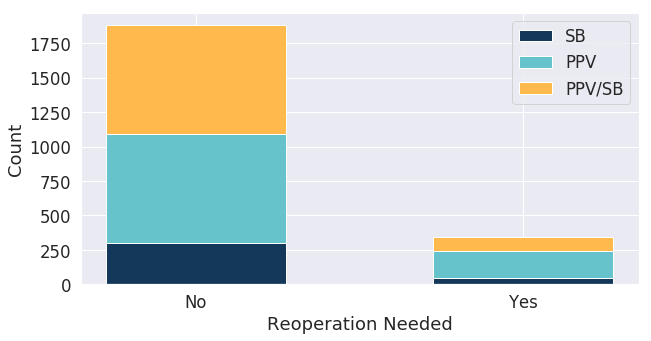

In [32]:
# Visualizing the contigency table with a stacked bar chart
def graph(contingency_table):
  surgery_1 = contingency_table.iloc[0][0:2].values
  surgery_2 = contingency_table.iloc[1][0:2].values
  surgery_3 = contingency_table.iloc[2][0:2].values

  fig = plt.figure(figsize=(10,5))
  sns.set(font_scale=1.5)
  categories = ["No", "Yes"]
  p1 = plt.bar(categories, surgery_1, 0.55, color='#143859')
  p2 = plt.bar(categories, surgery_2, 0.55, bottom=surgery_1, color='#66C3CC')
  p3 = plt.bar(categories, surgery_3, 0.55, bottom=surgery_2, color='#FFB94D')
  plt.legend( (p1[0], p2[0], p3[0]), ('SB', 'PPV', 'PPV/SB') )
  plt.xlabel('Reoperation Needed')
  plt.ylabel('Count')
  plt.show()
  return [surgery_1, surgery_2, surgery_3]
  
surgeries = graph(contingency_table)

We're interested in knowing if there is a relationship between the surgery chosen and whether a re-operation was necessary. Our null and alternative hypotheses are then as follows:


$H_0$: There is **no** statistically sigificant relationship between the surgery and whether there was a re-operation.

$H_a$: There is a statistically significant relationship between the surgery and whether there was a re-operation.




In order to determine whether we accept or reject the null hypothesis, we have to comput to P-value. For testing with two categorical variables, the Chi-squared statistic is calculated as follows:

 $X^2 = \frac{(observed - expected)^2}{(expected)}$



where the $observed$ are values we have in our contigency table and $expected$ are values we would expect assuming $H_0$ is true.

In [33]:
# Finding our observed values
f_obs = np.array(surgeries)
f_obs

array([[ 302,   48],
       [1094,  239],
       [ 785,  107]])

In [34]:
# Calculating the expected values
row_sums = contingency_table.iloc[0:3,2].values 
col_sums = contingency_table.iloc[3, 0:2].values
total = contingency_table.loc['All', 'All']

f_expected = []
for i in range(3):
  for j in col_sums:
     f_expected.append(j * row_sums[i]/total)

f_expected

[296.4466019417476,
 53.55339805825243,
 1129.0380582524272,
 203.9619417475728,
 755.5153398058252,
 136.48466019417475]

Now that we have all our observed and expected values, we can plug everything into the Chi-squared test equation.

Before we can determine the P-value, we also have to calculate the degrees of freedom.

 $DoF = (rows - 1) * (columns - 1)$

In [35]:
# Determining the degrees of freedom
dof = (len(row_sums) - 1) * (len(col_sums) - 1)
print("Our degrees of freedom is {}".format(dof))

Our degrees of freedom is 2


In [38]:
print("Our chi-squared test statistic is {}".format(chi_squared))

Our chi-squared test statistic is 15.306567797505801


In [37]:
# Calculating P-value
chi_squared, p_value, dof, expected = stats.chi2_contingency(f_obs)
print("Our P-value is {}".format(p_value))

Our P-value is 0.0004744834123210247


**Because our P-value  of 0.0005 < 0.05, we reject our null hypothesis. We conclude that these results are statistically significant with 99.95% confidence.**

However, let's now test for statistical significance based on age groups (41-50 vs. 51-60). We'll still use the chi-squared test of independence.

In [40]:
  ages_40_50

reoperation,0,1,All
surgery,,,
1,41,9,50
2,92,16,108
3,87,11,98
All,220,36,256


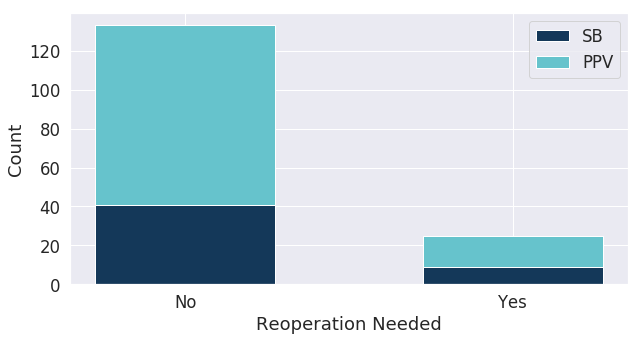

In [41]:
# Graphing the surgeries of the age group 40-50
surgery_1 = ages_40_50.iloc[0][0:2].values
surgery_2 = ages_40_50.iloc[1][0:2].values

fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
categories = ["No", "Yes"]
p1 = plt.bar(categories, surgery_1, 0.55, color='#143859')
p2 = plt.bar(categories, surgery_2, 0.55, bottom=surgery_1, color='#66C3CC')
plt.legend( (p1[0], p2[0]), ('SB', 'PPV') )
plt.xlabel('Reoperation Needed')
plt.ylabel('Count')
plt.show()
surgeries_40_50 = [surgery_1, surgery_2]


f_obs_40_50 = np.array(surgeries_40_50)

# Calculating P-value for age group 40-50
chi_squared_40_50, p_value_40_50, dof_40_50, expected_40_50 = stats.chi2_contingency(f_obs_40_50)

In [42]:
print("Our P-value for the age group 40-50 is {}".format(p_value_40_50))

Our P-value for the age group 40-50 is 0.7826409334363924


**Because our P-value of 0.78 > 0.05, this is *not* statistically significant for the age group of 40-50 years.**

Now, let's do the same for the age group 51-60.

In [43]:
ages_51_60

reoperation,0,1,All
surgery,,,
1,98,10,108
2,346,72,418
3,285,37,322
All,729,119,848


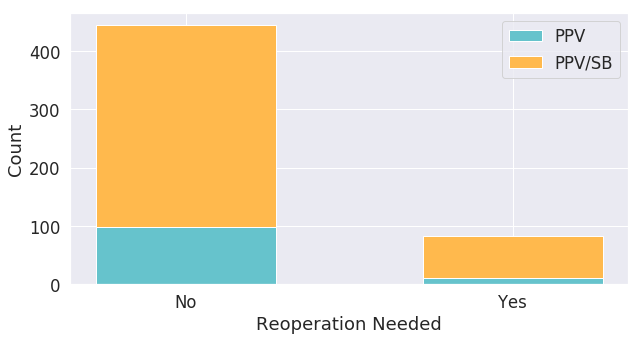

In [44]:
# Graphing the surgeries of the age group 41-50
surgery_2 = ages_51_60.iloc[0][0:2].values
surgery_3 = ages_51_60.iloc[1][0:2].values

fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
categories = ["No", "Yes"]
p1 = plt.bar(categories, surgery_2, 0.55, color = '#66C3CC')
p2 = plt.bar(categories, surgery_3, 0.55, bottom=surgery_2, color = '#FFB94D')
plt.legend( (p1[0], p2[0]), ('PPV', 'PPV/SB') )
plt.xlabel('Reoperation Needed')
plt.ylabel('Count')
plt.show()
surgeries_51_60 = [surgery_2, surgery_3]


f_obs_51_60 = np.array(surgeries_51_60)

# Calculating P-value for age group 41-50
chi_squared_51_60, p_value_51_60, dof_51_60, expected_51_60 = stats.chi2_contingency(f_obs_51_60)

In [45]:
print("Our P-value for the age group 51-60 is {}".format(p_value_51_60))

Our P-value for the age group 51-60 is 0.05936047935612663
